In [1]:
from ngsolve import *
from ngsolve.meshes import Make1DMesh
import matplotlib.pyplot as plt
import numpy as np
import time as timeit
from aux import *

%matplotlib notebook

ngsglobals.msg_level=1

def FVSolveBot(case=2, nx=200, k = 0, cfl=0.5, method ="RK2", 
               eps0 = 1e-12, maxV = 10, epsRho=5e-3, plot=False, 
               tol = 0.02, flag="char", pcBot=False, limitB=True):
    time = 0
    count = 0
    g = 9.812
    eps = (2/g)**0.5
    
    # parameters
    tend = 0.1
    b0 = sin(pi*x)**2
    rhoI = 5+exp(cos(2*pi*x))
    rhobI = rhoI+b0
    uI = sin(cos(2*pi*x))/rhoI
    xL = 0
    xR = 1
    tgrid = [tend,20]  
    
    h0 = (xR-xL)/nx

    mesh = Make1DMesh(n=nx, mapping=lambda x:xL+(xR-xL)*x, periodic=True)
    
    n = specialcf.normal(mesh.dim)
    # Burgers
    V = L2(mesh, order=k, all_dofs_together=False)
    fes = FESpace([V,V])

    bh = GridFunction(V)
    # default is an L2 proj
    helper = GridFunction(Periodic(H1(mesh, order=k)))
    helper.Set(b0)
    bh.Set(helper)
    helper.Set(rhobI)
    rhobI = helper
    
    gfu = GridFunction(fes)
    gfu0 = GridFunction(fes)
    
    rhoh, uh = gfu.components
    rhoh0, uh0 = gfu0.components
    mh = GridFunction(V) # momentum
    mh0 = GridFunction(V) # momentum
        
    (rho, u), (eta, v) = fes.TnT()

    ### LF flux
    rhoO = rho.Other()
    uO = u.Other()

    avg_u = 0.5*(u+uO)

    # Hydro static reconstruction
    rhoL = rho
    rhoR = rhoO
    jmp_rho = rho-rhoO
    avg_rho = 0.5*(rho+rhoO)+bh
    
    cL = (2*rhoL)**0.5/eps
    cR = (2*rhoR)**0.5/eps
    abs_uL = IfPos(u, u, -u)
    abs_uR = IfPos(uO, uO, -uO)
    
    speedL = cL+abs_uL
    speedR = cR+abs_uR

    ### ESTIMATE SPEED ?! FIXME LATER
    speed_rho = IfPos(speedL-speedR, speedL, speedR)        
    speed_u = speed_rho    
    
    # EEC flux + stab (LLF)
    flux_rho = 0.5*(rhoL*u+rhoR*uO)*n + 0.5*speed_rho*jmp_rho
    flux_m = flux_rho*avg_u + 0.5*speed_u*avg_rho*(u-uO)
    
    # Spatial operator (for rho updates)
    a = BilinearForm(fes)
    # mass eqn
    if k>0:
        # volume integration -- eqn 1
        a += -rho*u*grad(eta)*dx
        # volume integration -- eqn 2 (convection)
        a += (-0.5*rho*u**2*grad(v)+0.5*rho*u*grad(u)*v)*dx
        # volume integration -- eqn 2 (gravitation)
        a += g*(grad(rho)+grad(bh))*rho*v*dx
        
    # interial node integration -- eqn 1    
    a += flux_rho*(eta-eta.Other())*dx(skeleton=True)
    
    # interial node integration -- eqn2 (convection-- part 1)
    a += flux_m*(v-v.Other())*dx(skeleton=True)
    # interial node integration -- eqn2 (convection-- part 2)
    a += -0.5*flux_rho*(u*v-uO*v.Other())*dx(skeleton=True)
    # interial node integration -- eqn2 (gravitation)
    a += -g*jmp_rho*n*0.5*(rhoL*v+rhoR*v.Other())*dx(skeleton=True)
            

    ### INITIAL DATA (HACK)
    uh.Set(uI)
    rhoh.Set(rhobI) # THIS INTRODUCE NUMERICAL ERROR !    
    rhoh.vec.data -= bh.vec # remove bottom
    
    # add mh
    mh.vec.data = uh.vec
    V.ApplyM(rho=rhoh, vec=mh.vec)
    V.SolveM(rho=1, vec=mh.vec)
    
    tmp = gfu.vec.CreateVector()
    
    tmpU = uh.vec.CreateVector()
    tmpU0 = uh.vec.CreateVector()
    tmpU1 = uh.vec.CreateVector()
    nrho = V.ndof

    step = 0

    vel = GridFunction(L2(mesh))
    vel.Set((2*rhoh)**0.5/eps+((uh)**2)**0.5)
    dt = cfl*h0/max(vel.vec)

    nelems = mesh.ne
    # cell center points
    pnts_x = np.linspace(xL+0.5*h0, xR-0.5*h0, nx)              
    
    pnts_rho = []
    pnts_b = []
    pnts_u = [] 
    pnts_m = [] 
    
    listNbs = getNeighbors1D(mesh)            
        
    def ForwardEuler(dt):
        # evaluate the bilinear form
        a.Apply(gfu.vec, tmp)
        # tmpU is rho_old * u_old *v
        tmpU.data = uh.vec
        V.ApplyM(rho=rhoh, vec=tmpU)
        tmp[nrho:].data += 0.5/dt*tmpU
        
        # (1) solve for density inc.
        # (1) update density (unlimited)       
        V.SolveM(rho=1, vec=tmp[:nrho])       
        rhoh.vec.data -= dt*tmp[:nrho]
        
        # update derivative (use unlimited den)
        # tmpU is rho_new * u_old *v
        tmpU.data = uh.vec
        V.ApplyM(rho=rhoh, vec=tmpU)
        tmp[nrho:].data -= 0.5/dt*tmpU

        # update momentum (unlimited)
        V.SolveM(rho=1, vec=tmp[nrho:])
        mh.vec.data -= dt*tmp[nrho:]
    
    # convex combination
    def ConvexComb(w0, w1):
        # update density
        rhoh.vec.data *= w1
        rhoh.vec.data += w0*rhoh0.vec

        # update momentum
        mh.vec.data *= w1
        mh.vec.data += w0*mh0.vec
        
    def CalcVel():
        tmpU.data = mh.vec
        V.ApplyM(rho=1, vec=tmpU)
        V.SolveM(rho=rhoh, vec=tmpU)
        uh.vec.data = tmpU 
        if maxV >0:
            mat = []
            nlimit = limitU1D(uh, nelems, k, mat, maxV=maxV)
        else:
            nlimit = 0
        return nlimit

    # limit den + mh
    def Limit():
        if k > 0 and epsRho > 0:
            # (1) avg_rho < epsRho: use lowest order P0 approximation
            drylimit1D(rhoh, mh, k, nelems, epsRho=epsRho)
        
        # (2) tvb limit
        maskM, nlimit = tvbLimitM1D(rhoh, mh, bh, k, nelems, listNbs, tol, 
                                  flag=flag, g=g, epsRho=epsRho, limitB=limitB)
            
        # (3) pplimit
        pplimit(rhoh, k, mips, npts,  nelems, mw, eps0=eps0)
        return maskM, nlimit
        
    if plot==True:
        pb = np.array([bh(x) for x in pnts_x])
        prho = np.array([rhoh(x) for x in pnts_x])
        pu = np.array([uh(x) for x in pnts_x])
        pm = np.array([mh(x) for x in pnts_x])
        fig = plt.figure()
        ax1 = plt.subplot(1,2,1)
        ax2 = plt.subplot(1,2,2)
        line1, = ax1.plot(pnts_x, prho+pb,'b+-')
        line2, = ax2.plot(pnts_x, pm,'b+-')
        line3, = ax1.plot(pnts_x[5], prho[5],'r+')
        if case=="2a":
            ax1.set_ylim([0.999,1.001])
            ax2.set_ylim([-0.002,0.002])
        elif case=="2b":
            ax1.set_ylim([0.8,1.2])
            ax2.set_ylim([-0.5,0.5])
            
    mask, nlimit= 0,0
    with TaskManager():
        while time < tend:
            time += dt
            if time > tend:
                time -= dt
                dt = tend-time
                time = tend
            step += 1
            gfu0.vec.data = gfu.vec
            mh0.vec.data = mh.vec

            ### RK3 stage 1
            ForwardEuler(dt)
            CalcVel()
                  
            ForwardEuler(dt)
            ConvexComb(0.75, 0.25)
            CalcVel()

            ForwardEuler(dt)
            ConvexComb(1/3, 2/3)
            CalcVel()
            
            # estimate based on cell-averages        
            vel.Set((2*rhoh)**0.5/eps+((uh)**2)**0.5)
            vmax = max(vel.vec)
            dt = cfl*h0/vmax                
        print(time, "\n")
        return rhoh, uh, mh


In [2]:
%%time
# reference soln on mesh with 1600 cells
rhoX, uX, mX = FVSolveBot(nx = 1600, k=2, cfl = 0.1, method="RK3", maxV=0)

0.1 

CPU times: user 2h 33min 38s, sys: 1h 14min 29s, total: 3h 48min 8s
Wall time: 7min 9s


In [3]:
%%time
## reference solution
rhoList, uList, mList = [], [], []
for i in range(5):
    nx = 50*2**i
    rhoh, uh, mh = FVSolveBot(nx = nx, k=2, cfl = 0.1, method="RK3", maxV=0)
    rhoList.append(rhoh)
    uList.append(uh)
    mList.append(mh)

0.1 

0.1 

0.1 

0.1 

0.1 

CPU times: user 1h 16min 41s, sys: 44min 23s, total: 2h 1min 4s
Wall time: 3min 54s


In [4]:
# calculation L2-errors
mesh = rhoX.space.mesh
for i in range(5):
    # L2 errors
    errR = sqrt(Integrate((rhoList[i]-rhoX)**2, mesh))
    errU = sqrt(Integrate((uList[i]-uX)**2, mesh))
    errM = sqrt(Integrate((mList[i]-mX)**2, mesh))
    # L1 errors
#     errR = Integrate(((rhoList[i]-rhoX)**2)**0.5, mesh)
#     errU = Integrate(((uList[i]-uX)**2)**0.5, mesh)
#     errM = Integrate(((mList[i]-mX)**2)**0.5, mesh)
    if i ==0:
        print("%3i& %.3e & -- & %.3e & -- & %.3e &-- \\\\"%(50*2**i, errR, errU, errM))
    else:
        rateR = -log(errR/errR0)/log(2)
        rateU = -log(errU/errU0)/log(2)
        rateM = -log(errM/errM0)/log(2)
        print("%3i& %.3e & %.2f & %.3e & %.2f & %.3e & %.2f \\\\"%(50*2**i, errR, rateR, errU, 
                                                                 rateU, errM, rateM))
    errR0 =errR
    errU0 = errU
    errM0 = errM    

 50& 2.997e-04 & -- & 3.583e-04 & -- & 2.577e-03 &-- \\
100& 2.730e-05 & 3.46 & 3.273e-05 & 3.45 & 2.352e-04 & 3.45 \\
200& 2.949e-06 & 3.21 & 3.538e-06 & 3.21 & 2.542e-05 & 3.21 \\
400& 3.600e-07 & 3.03 & 4.323e-07 & 3.03 & 3.103e-06 & 3.03 \\
800& 4.408e-08 & 3.03 & 5.296e-08 & 3.03 & 3.798e-07 & 3.03 \\


<IPython.core.display.Javascript object>


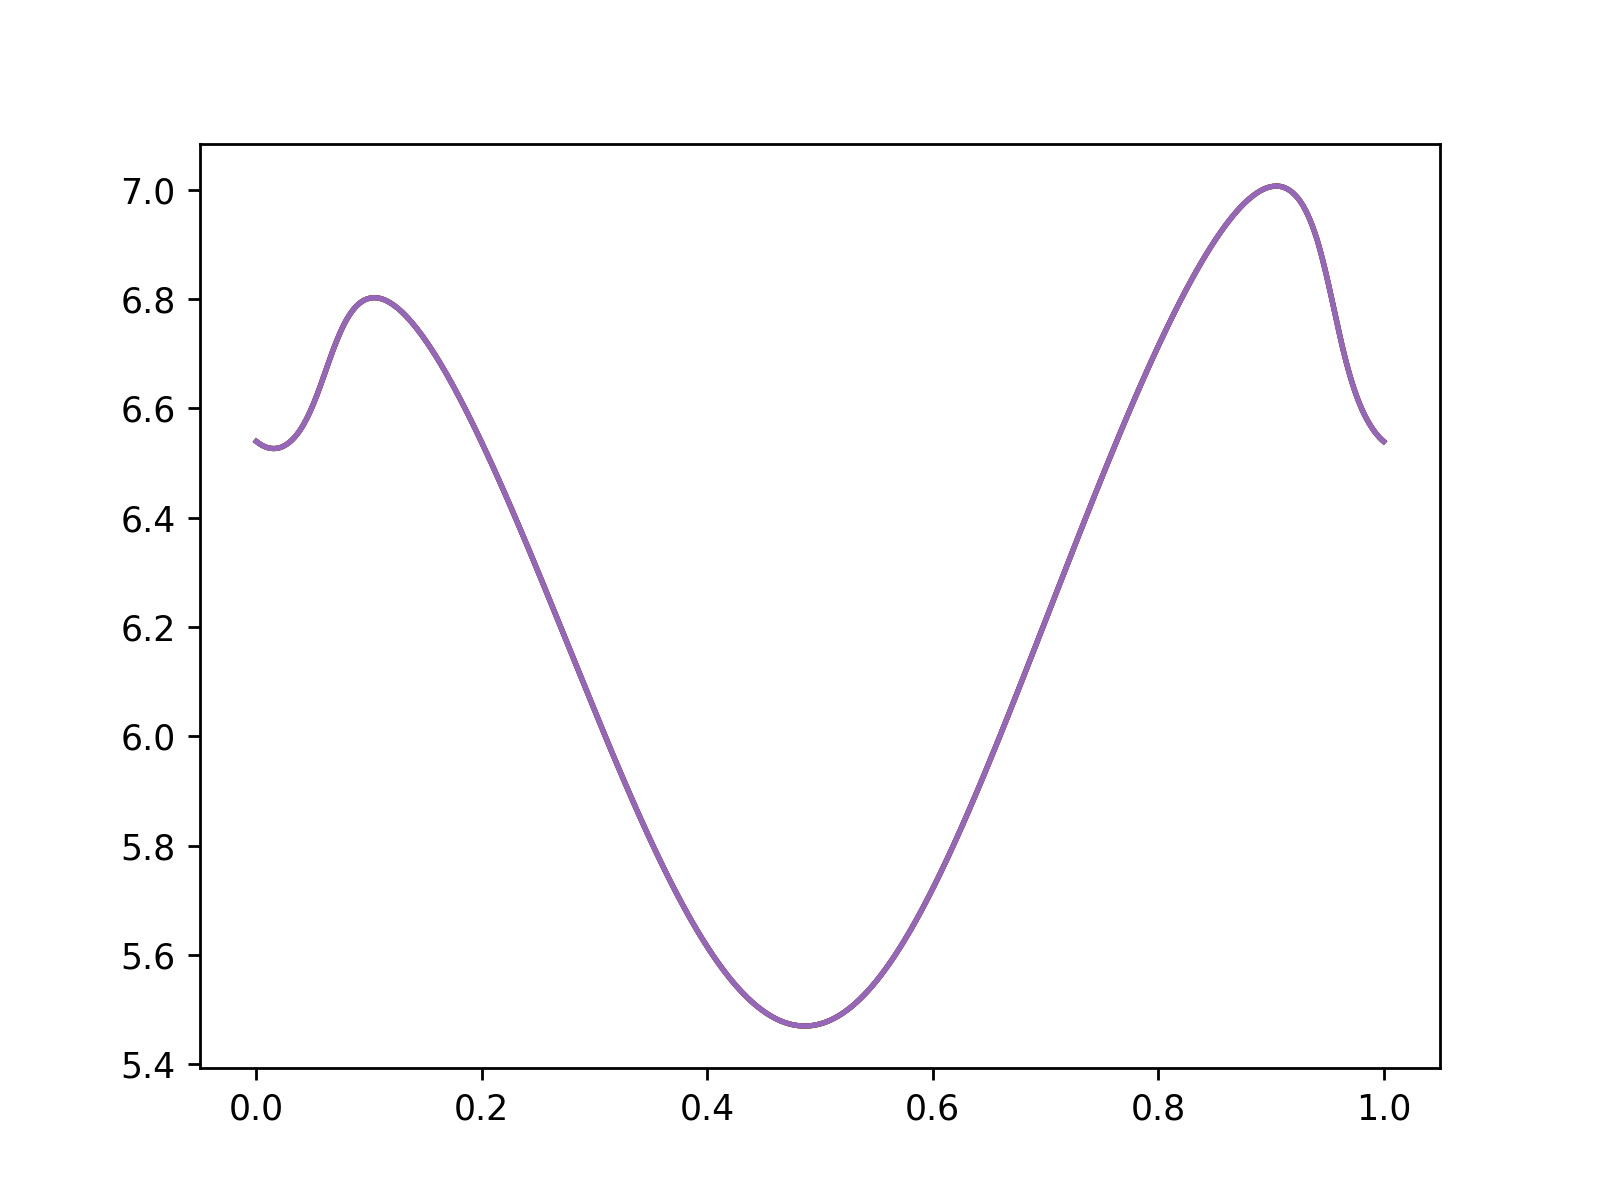

In [5]:
pnts = np.linspace(0,1, 1000)
plt.figure()
for i in range(5):
    pnts_r = np.array([rhoList[i](mesh(x)) for x in pnts])
    plt.plot(pnts, pnts_r)